# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

nRows = 10
print('\u2022The general demographics data have', azdias.shape[0], 'rows and', azdias.shape[1], 'columns.')
print('\u2022The first',nRows,'Rows are:')
print(azdias.head(10))

print('\n\n')
print('\u2022The feature summaries have', feat_info.shape[0], 'rows and', feat_info.shape[1], 'columns.')
print('\u2022The first',nRows,'Rows are:')
print(feat_info.head(10))

#azdias.to_csv('Udacity_AZDIAS_Subset_comma.csv')
#feat_info.to_csv('AZDIAS_Feature_Summary_comma.csv')

•The general demographics data have 891221 rows and 85 columns.
•The first 10 Rows are:
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   
5         3                     1          2            2.0   
6        -1                     2          2            5.0   
7        -1                     1          1            3.0   
8        -1                     3          1            3.0   
9        -1                     3          2            4.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# Identify missing or unknown data values and convert them to NaNs.
for iFeature in range(0, feat_info.shape[0]):
    feature       = feat_info['attribute'][iFeature]   # get feature name
    npType        = type(azdias[feature][0])           # get datatype of the feautre in the general demographics data
    
    if len(feat_info['missing_or_unknown'][iFeature]) == 2:  # '[]': no codes for missing or unknown data for that feature 
        continue
   
    # find the codes for the feature 
    #misOrUnknown = np.asarray(feat_info['missing_or_unknown'][iFeature][1:-1].split(','),npType)
    missOrUnknown = feat_info['missing_or_unknown'][iFeature][1:-1].split(',')
   
    for mu in missOrUnknown:
        if mu <= '9': # code that is a number
            missUnknown     = npType(mu)
        else:   # code that is a character or string, e.g 'X','XX'
            missUnknown     = mu
            
        azdias[feature] = azdias[feature].replace(missUnknown, np.nan)
    
#azdias.to_csv('Udacity_AZDIAS_Subset_processed.csv')
print(azdias.head(10))

   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   2.0          1            2.0   
1       NaN                   1.0          2            5.0   
2       NaN                   3.0          2            3.0   
3       2.0                   4.0          2            2.0   
4       NaN                   3.0          1            5.0   
5       3.0                   1.0          2            2.0   
6       NaN                   2.0          2            5.0   
7       NaN                   1.0          1            3.0   
8       NaN                   3.0          1            3.0   
9       NaN                   3.0          2            4.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3             

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [5]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
colNAN = np.empty(0)
for iFeature in range(0, feat_info.shape[0]):
    feature  = feat_info['attribute'][iFeature]   # get feature name
    colNAN = np.append(colNAN, azdias[feature].isna().sum())

colNANpct = colNAN/azdias.shape[0]  

print('Missing data for each columns are:')
print(colNAN)
print('\nPercentage of Missing data for each columns are:')
print(colNANpct)

Missing data for each columns are:
[685843.   2881.      0.   4854.      0.      0.      0.      0.      0.
      0.      0. 392318.   4854.      0. 111196.  97632.  94572.  77792.
  77792.   4854.   4854. 108315. 108164.   4854.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0. 111196.  73499. 889061. 111196.      0. 310267.  73499.
  73499.  18348. 584612. 147988.  73499.  99611.  97008.  93148.  73969.
  93148.  93148.  93148.  99352.  99352.  99352. 133324. 133324. 133324.
 133324. 476524. 133324.  93740.  93740.  93740.  93155. 158064. 133324.
   4854. 158064. 105800. 116515. 116515. 116515. 116515. 116515. 116515.
 116515.  97375.  97274.  97375.]

Percentage of Missing data for each columns are:
[0.76955435 0.00323264 0.         0.00544646 0.         0.
 0.         0.         0.         0.         0.         0.44020282
 0.00544646 0.         0.12476816 0.10954859 0.10611509 0.08728699
 0.08728699 0.00544646 0.005446

Text(0.5, 1.0, 'Histogram of missing data proportion for 85 features')

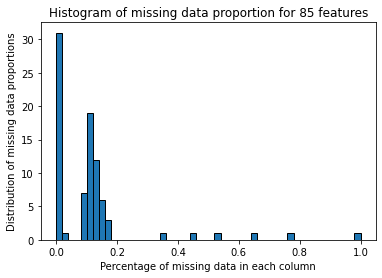

In [6]:
# Investigate patterns in the amount of missing data in each column.
plt.figure()
plt.hist(colNANpct, bins=50, range=(0., 1.), edgecolor='k')
plt.xlabel("Percentage of missing data in each column")
plt.ylabel("Distribution of missing data proportions")
plt.title("Histogram of missing data proportion for {} features".format(feat_info.shape[0]))


In [7]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Can only run this cell once because azdias has columns drops and can not be dropped twice

# Based on the histogram figures, columns with > 20% missing data will be removed
colThre   = 0.2

cols_drop = pd.DataFrame(index = range(azdias.shape[0]))
feat_drop = np.empty(0, dtype = str)

for iFeature in range(0, feat_info.shape[0]):
    if colNANpct[iFeature] > colThre:
        feature   = feat_info['attribute'][iFeature]  
        cols_drop = cols_drop.join(azdias[feature])    # store the dropped columns in another df
        feat_drop = np.append(feat_drop,feature)
        
azdias = azdias.drop(feat_drop, axis = 1)

#azdias.to_csv('Udacity_AZDIAS_Subset_colDropped.csv')
print('{} columns are dropped. They are:'.format(len(feat_drop)))
print(feat_drop)
print('The general demographics data now have', azdias.shape[0], 'rows and', azdias.shape[1], 'columns.')

6 columns are dropped. They are:
['AGER_TYP' 'GEBURTSJAHR' 'TITEL_KZ' 'ALTER_HH' 'KK_KUNDENTYP'
 'KBA05_BAUMAX']
The general demographics data now have 891221 rows and 79 columns.


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

<span style="color:blue">

#### Answer:
The histogram shows a bimodal distribution. The two peaks show up at around 0% missing data and around 10% missing data, respectively. For most columns, missing data are less than 20%. Only six columns have > 20% missing data, looking like a long tail in the bimodal distribution. So the six columns are considered as outliers and removed from the general demographics data. The six columns are 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', and 'KBA05_BAUMAX'.

</span>


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

Missing data for first 20 rows are:
0     43
1      0
2      0
3      7
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11    47
12     6
13     8
14    47
15     8
16     6
17    47
18     3
19     0
dtype: int64

Percentage of missing data for first 20 rows are:
0     0.544304
1     0.000000
2     0.000000
3     0.088608
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.594937
12    0.075949
13    0.101266
14    0.594937
15    0.101266
16    0.075949
17    0.594937
18    0.037975
19    0.000000
dtype: float64


Text(0.5, 1.0, 'Histogram of missing data proportion for 891221 rows')

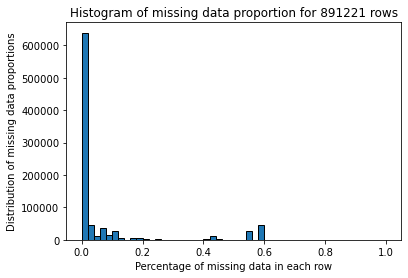

In [8]:
# How much data is missing in each row of the dataset?
#rowNAN = np.empty(0)
#for iRow in range(0, azdias.shape[0]):
#    rowNAN = np.append(rowNAN, azdias.loc[[iRow]].isna().sum().sum())

#rowNANpct = rowNAN/azdias.shape[1]     

# The code above takes too long time to complete

rowNAN    = azdias.isna().sum(axis = 1)
rowNANpct = rowNAN/azdias.shape[1]   # azdias here already has outlier features dropped, shape is 891221*79

print('Missing data for first 20 rows are:')
print(rowNAN[0:20])
print('\nPercentage of missing data for first 20 rows are:')
print(rowNANpct[0:20])

# Similar to identify columns outliers, histogram is plot to help find the threshreshold
plt.figure()
plt.hist(rowNANpct, bins=50, range=(0., 1.), edgecolor='k')
plt.xlabel("Percentage of missing data in each row")
plt.ylabel("Distribution of missing data proportions")
plt.title("Histogram of missing data proportion for {} rows".format(azdias.shape[0]))


In [9]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# set threshold = 0.3 based on the histogram
rowThre      = 0.3
subset_below = azdias[rowNANpct <= rowThre]
subset_above = azdias[rowNANpct > rowThre]
# azdias['label'] = np.multiply(rowNANpct <= rowThre, 1)

print('\u2022The subset below the threshold (no or few missing data) has a shape:', subset_below.shape)
print('\u2022The subset above the threshold (having many missng values) has a shape:', subset_above.shape)

•The subset below the threshold (no or few missing data) has a shape: (797837, 79)
•The subset above the threshold (having many missng values) has a shape: (93384, 79)


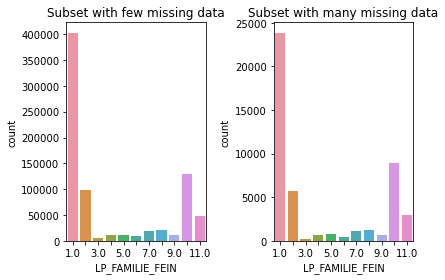

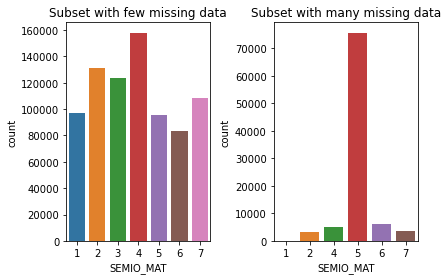

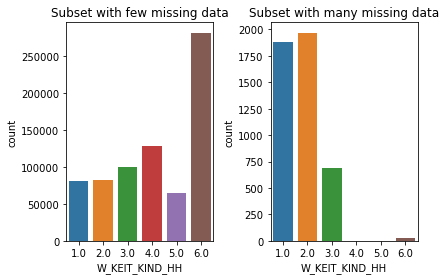

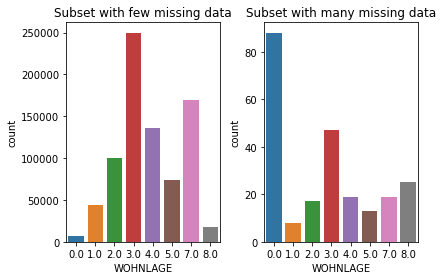

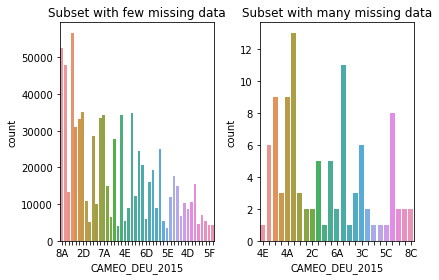

KBA05_GBZ has no data in the subset with many missing data


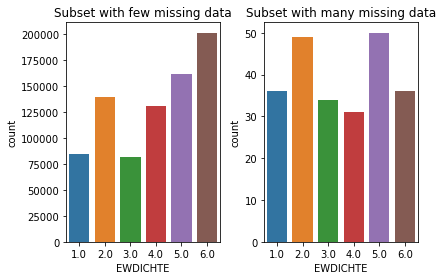

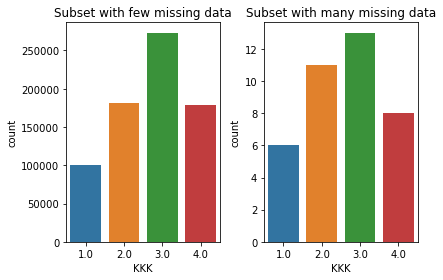

In [10]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def distrCompare(dataset1, dataset2, feature):
    '''
    compare the distribution of the data of a feature between two datasets, and plot the results
    '''
    plt.figure()
    # subplot 1
    ax1 = plt.subplot(1,2,1)
    sns.countplot(data = dataset1, x =feature)
    # sns.histplot(data = dataset1, x=feature, stat = 'probability')
    ax1.set_title('Subset with few missing data')
    
    # reduce the number of X ticks if too many
    interval = 1
    numTicks = len(ax1.get_xticklabels())
    while numTicks/interval>8.0:
        interval = interval + 1
        
    for index, label in enumerate(ax1.get_xticklabels()):
        if index % interval == 0:
            label.set_visible(True)
        else:
            label.set_visible(False)
    
    # subplot 2
    ax2 = plt.subplot(1,2,2)
    sns.countplot(data = dataset2, x = feature)
    ax2.set_title('Subset with many missing data')
    
    # reduce the number of X ticks if too many
    interval = 1
    numTicks = len(ax2.get_xticklabels())
    while numTicks/interval>8.0:
        interval = interval + 1
        
    for index, label in enumerate(ax2.get_xticklabels()):
        if index % interval == 0:
            label.set_visible(True)
        else:
            label.set_visible(False)
    
    plt.tight_layout()
    plt.show()

# > 5 features to be tested
test_feats = ['LP_FAMILIE_FEIN', 'SEMIO_MAT', 'W_KEIT_KIND_HH','WOHNLAGE','CAMEO_DEU_2015', 'KBA05_GBZ','EWDICHTE','KKK']

for feature in test_feats:
    if feature in feat_drop:    # the feature has already been dropped
        print(feature,'has a lot of NAN data and has been dropped.')
        continue
    elif subset_above[feature].notna().sum() ==0: # no data at all
        print(feature, 'has no data in the subset with many missing data')
        continue
        
    distrCompare(subset_below, subset_above, feature)



#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

<span style="color:blue">

#### Answer:
Based on the selected 8 features compared above, rows with lots of missing values can have similar distributions to the rows with few missing values, for e.g. "LP_FAMILIE_FEIN", "SEMIO_MAT" and "KKK". For the remaining 5 features, the two row data subsets are qualitatively different from each other. The most extreme case is observed for "KBA05_GBZ" - one subset (with many missing data) has no data for this feature. 

</span>

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [11]:
# How many features are there of each data type?
# before dropp and after dropp   
print('\nAmong the original', feat_info.shape[0], 'columns of the general demographics data, numbers of features of different data types are:')
print(feat_info['type'].value_counts())

feat_info_dropped = feat_info[feat_info['attribute'].isin(feat_drop) == False]

print('\nAfter', len(feat_drop), 'outlier columns were dropped in previous sections, numbers of features of different data types are:')
print(feat_info_dropped['type'].value_counts())

#further remove features that have no variations
for feature in feat_info_dropped['attribute']:
    if len(azdias[feature].value_counts())==1:    # no variations in values
        feat_drop = np.append(feat_drop,feature)

        
if(len(feat_drop) == 6):
    print('Values in remaining features all have variations.')

feat_cat = feat_info_dropped['attribute'].loc[feat_info_dropped['type'].values=='categorical']
feat_mix = feat_info_dropped['attribute'].loc[feat_info_dropped['type'].values=='mixed']
print('\nCategorical features include:')
print(feat_cat)
print('\nMixed-type features include:')
print(feat_mix)



Among the original 85 columns of the general demographics data, numbers of features of different data types are:
ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

After 6 outlier columns were dropped in previous sections, numbers of features of different data types are:
ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64
Values in remaining features all have variations.

Categorical features include:
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

Mixed-type features include:
15      L

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [12]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feat_cat        = feat_cat.tolist()
feat_cat_encode = np.empty(0, dtype = str)
feat_cat_noenc  = np.empty(0, dtype = str)

print('Values in each categorical variables: ')
for feature in feat_cat:
    print('\n')
    print(azdias[feature].value_counts())
    if type(azdias[feature][0])!=np.int64 and type(azdias[feature][0])!=np.float64:
        feat_cat_encode = np.append(feat_cat_encode, feature)
    elif len(azdias[feature].value_counts()) >=3:
        feat_cat_encode = np.append(feat_cat_encode, feature)
    else:
        feat_cat_noenc  = np.append(feat_cat_noenc, feature)
        
    
print('\nCategorical features not to be encoded (binary and numeric):')
print(feat_cat_noenc)
print('\nCategorical features to be encoded (multiple or not numeric):')
print(feat_cat_encode)


Values in each categorical variables: 


2    465305
1    425916
Name: ANREDE_KZ, dtype: int64


4.0    210963
3.0    156449
6.0    153915
2.0    148795
5.0    117376
1.0     98869
Name: CJT_GESAMTTYP, dtype: int64


6    290367
1    199572
4    130625
2    110867
5    106436
3     53354
Name: FINANZTYP, dtype: int64


12.0    138545
5.0     120126
10.0    109127
8.0      88042
11.0     79740
4.0      63770
9.0      60614
3.0      56007
1.0      53600
2.0      46702
7.0      42956
6.0      27138
Name: GFK_URLAUBERTYP, dtype: int64


0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64


1.0     426379
10.0    137913
2.0     104305
11.0     51719
8.0      23032
7.0      20730
4.0      12303
5.0      11920
9.0      11148
6.0       9022
3.0       4958
Name: LP_FAMILIE_FEIN, dtype: int64


1.0    426379
5.0    200780
2.0    104305
4.0     52784
3.0     29181
Name: LP_FAMILIE_GROB, dtype: int64


1.0     219275
9.0     143238
2.0     118236
10.0    118022
4.0      78317
5.0      744

In [13]:
# Re-encode categorical variable(s) to be kept in the analysis.

azdias_encoded = pd.DataFrame(index = range(azdias.shape[0]))
for feature in feat_info_dropped['attribute']:
    if feature in feat_cat_encode:
        encoded = pd.get_dummies(azdias[feature],prefix = feature)
        azdias_encoded = azdias_encoded.join(encoded)
    else:
        azdias_encoded = azdias_encoded.join(azdias[feature])
        
print('After encoding categorical features, the general demographics dataset has',azdias_encoded.shape[1],'columns.')        
print('\nThe columns in the new dataset are:')
print(list(azdias_encoded.columns))


After encoding categorical features, the general demographics dataset has 195 columns.

The columns in the new dataset are:
['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP_1.0', 'CJT_GESAMTTYP_2.0', 'CJT_GESAMTTYP_3.0', 'CJT_GESAMTTYP_4.0', 'CJT_GESAMTTYP_5.0', 'CJT_GESAMTTYP_6.0', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP_1', 'FINANZTYP_2', 'FINANZTYP_3', 'FINANZTYP_4', 'FINANZTYP_5', 'FINANZTYP_6', 'GFK_URLAUBERTYP_1.0', 'GFK_URLAUBERTYP_2.0', 'GFK_URLAUBERTYP_3.0', 'GFK_URLAUBERTYP_4.0', 'GFK_URLAUBERTYP_5.0', 'GFK_URLAUBERTYP_6.0', 'GFK_URLAUBERTYP_7.0', 'GFK_URLAUBERTYP_8.0', 'GFK_URLAUBERTYP_9.0', 'GFK_URLAUBERTYP_10.0', 'GFK_URLAUBERTYP_11.0', 'GFK_URLAUBERTYP_12.0', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN_1.0', 'LP_FAMILIE_FEIN_2.0', 'LP_FAMILIE_FEIN_3.0', 'LP_FAMILIE_FEIN_4.0', 'LP_FAMILIE_FEIN_5.0', 'LP_FAMILIE_FEIN_6.0', 'LP_

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

<span style="color:blue">

#### Answer:
The raw data of the general demographics dataset has 21 categorical features. 3 of them ('AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP') were removed due to too many missing data. 18 features were kept. 

Among the 18 categorical features kept, 4 of them ('ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP') are binary and numeric, so they are not changed. 1 feature ('OST_WEST_KZ') is binary but non-numeric; either re-coding it into numeric or creating a dummy variable for it works. Here I created a dummy variable for it and applied one-hot coding in the same way as what is done for multi-level features. The remaining 13 features ('CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015') are multi-leveled, and one-hot coding is applied to all of them. 

</span>

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [14]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.


feature = "PRAEGENDE_JUGENDJAHRE"
new_cols = pd.DataFrame(index = range(azdias.shape[0]),columns=['GENERATION','MOVEMENT'], dtype=np.int64)

new_cols['GENERATION'][np.logical_or(azdias[feature]==1, azdias[feature]==2)] = 40
new_cols['GENERATION'][np.logical_or(azdias[feature]==3, azdias[feature]==4)] = 50
new_cols['GENERATION'][np.logical_and(azdias[feature]>=5, azdias[feature]<=7)] = 60
new_cols['GENERATION'][np.logical_or(azdias[feature]==8, azdias[feature]==9)] = 70
new_cols['GENERATION'][np.logical_and(azdias[feature]>=10, azdias[feature]<=13)] = 80
new_cols['GENERATION'][np.logical_or(azdias[feature]==14, azdias[feature]==15)] = 90

# "Mainstream" represented by 0; "Avantgarde" represented by 1
new_cols['MOVEMENT'][np.logical_and(azdias[feature]<=6, np.mod(azdias[feature],2) == 1)] = 0 
new_cols['MOVEMENT'][np.logical_and(azdias[feature]<=6, np.mod(azdias[feature],2) == 0)] = 1
new_cols['MOVEMENT'][np.logical_and(azdias[feature]>=7, np.mod(azdias[feature],2) == 1)] = 1
new_cols['MOVEMENT'][np.logical_and(azdias[feature]>=7, np.mod(azdias[feature],2) == 0)] = 0

# Drop "PRAEGENDE_JUGENDJAHRE" and add two new columns
cols_drop = cols_drop.join(azdias[feature])   
feat_drop = np.append(feat_drop,feature)
feat_info_dropped = feat_info_dropped[feat_info_dropped['attribute'] != feature]
#azdias = azdias.drop(feature, axis = 1)
#azdias = azdias.join(new_cols)
azdias_encoded = azdias_encoded.drop(feature, axis = 1)
azdias_encoded = azdias_encoded.join(new_cols)

print('\nFirst 10 rows of the two new variables replacing \'PRAEGENDE_JUGENDJAHRE\':')
print(new_cols.head(10))


First 10 rows of the two new variables replacing 'PRAEGENDE_JUGENDJAHRE':
   GENERATION  MOVEMENT
0         NaN       NaN
1        90.0       0.0
2        90.0       1.0
3        70.0       0.0
4        70.0       0.0
5        50.0       0.0
6        80.0       0.0
7        70.0       0.0
8        80.0       1.0
9        90.0       1.0


In [15]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
feature = "CAMEO_INTL_2015"
new_cols = pd.DataFrame(index = range(azdias.shape[0]),columns=['WEALTH','LIFE_STAGE'], dtype=np.int64)

new_cols['WEALTH']     = np.floor(np.float64(azdias[feature])/10)
new_cols['LIFE_STAGE'] = np.mod(np.float64(azdias[feature]),10)  # mod(nan, 10) will give a warning, but returns nan

# Drop "CAMEO_INTL_2015" and add two new columns
cols_drop = cols_drop.join(azdias[feature])   
feat_drop = np.append(feat_drop,feature)
feat_info_dropped = feat_info_dropped[feat_info_dropped['attribute'] != feature]
#azdias = azdias.drop(feature, axis = 1)
#azdias = azdias.join(new_cols)
azdias_encoded = azdias_encoded.drop(feature, axis = 1)
azdias_encoded = azdias_encoded.join(new_cols)

print('\nFirst 10 rows of the two new variables replacing \'CAMEO_INTL_2015\':')
print(new_cols.head(10))

<ipython-input-15-aef6b2ee0671>:6: RuntimeWarning: invalid value encountered in remainder
  new_cols['LIFE_STAGE'] = np.mod(np.float64(azdias[feature]),10)  # mod(nan, 10) will give a warning, but returns nan



First 10 rows of the two new variables replacing 'CAMEO_INTL_2015':
   WEALTH  LIFE_STAGE
0     NaN         NaN
1     5.0         1.0
2     2.0         4.0
3     1.0         2.0
4     4.0         3.0
5     5.0         4.0
6     2.0         2.0
7     1.0         4.0
8     1.0         3.0
9     1.0         5.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

<span style="color:blue">

#### Answer:
The raw data of the general demographics dataset has 7 mixed-type features. 1 of them ('KBA05_BAUMAX') was removed due to too many missing data. 
    
Two of them ('PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015') had the information split into new variables to replace the original features. Each of them were split into two new variables.  

The remaining 4 features ('LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX') are all kept as they are. All 4 features are numeric. 'WOHNLAGE' and 'PLZ8_BAUX' both contain one-dimensional information and can be treated as multi-level categorical variables. Here I just leave them as they are for simplicity. 'LP_LEBENSPHASE_FEIN' and 'LP_LEBENSPHASE_GROB' both include multi-dimensional information and can be split into new variables. But because not all dimensional information is clearly stated for each label, I just keep them as they are for simplicity.

</span>

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)




In [16]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Drop rows with > threshold missing data
azdias_encoded = azdias_encoded[rowNANpct <= rowThre]
azdias_encoded = azdias_encoded.reset_index(drop = True)  # Othersize row index before row dropping will be kepted

print('\nFinally, features dropped:',feat_drop)
print('Dimensions of the general demographics dataset are',azdias_encoded.shape)        
print('The columns in the new dataset are:')
print(list(azdias_encoded.columns))



Finally, features dropped: ['AGER_TYP' 'GEBURTSJAHR' 'TITEL_KZ' 'ALTER_HH' 'KK_KUNDENTYP'
 'KBA05_BAUMAX' 'PRAEGENDE_JUGENDJAHRE' 'CAMEO_INTL_2015']
Dimensions of the general demographics dataset are (797837, 197)
The columns in the new dataset are:
['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP_1.0', 'CJT_GESAMTTYP_2.0', 'CJT_GESAMTTYP_3.0', 'CJT_GESAMTTYP_4.0', 'CJT_GESAMTTYP_5.0', 'CJT_GESAMTTYP_6.0', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP_1', 'FINANZTYP_2', 'FINANZTYP_3', 'FINANZTYP_4', 'FINANZTYP_5', 'FINANZTYP_6', 'GFK_URLAUBERTYP_1.0', 'GFK_URLAUBERTYP_2.0', 'GFK_URLAUBERTYP_3.0', 'GFK_URLAUBERTYP_4.0', 'GFK_URLAUBERTYP_5.0', 'GFK_URLAUBERTYP_6.0', 'GFK_URLAUBERTYP_7.0', 'GFK_URLAUBERTYP_8.0', 'GFK_URLAUBERTYP_9.0', 'GFK_URLAUBERTYP_10.0', 'GFK_URLAUBERTYP_11.0', 'GFK_URLAUBERTYP_12.0', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEI

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [17]:
def clean_data(df, featInfo, featDrop, rowThre):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
           Feature Summary that indicating how missing or unknow values are represented for each features
           Columns to be dropped for lots of missing data
           Row threshold for missing data
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    for iFeature in range(0, featInfo.shape[0]):
        feature       = featInfo['attribute'][iFeature]   # get feature name
        npType        = type(df[feature][0])           # get datatype of the feautre in the general demographics data
    
        if len(featInfo['missing_or_unknown'][iFeature]) == 2:  # '[]': no codes for missing or unknown data for that feature 
            continue
   
        missOrUnknown = featInfo['missing_or_unknown'][iFeature][1:-1].split(',')
   
        for mu in missOrUnknown:
            if mu <= '9': # code that is a number
                missUnknown     = npType(mu)
            else:   # code that is a character or string, e.g 'X','XX'
                missUnknown     = mu
            
            df[feature] = df[feature].replace(missUnknown, np.nan)   
    
    # remove selected columns and rows, ...
    #colNAN = np.empty(0)
    #for iFeature in range(0, featInfo.shape[0]):
    #    feature  = featInfo['attribute'][iFeature]  
    #    colNAN = np.append(colNAN, df[feature].isna().sum())
        
    # colNANpct = colNAN/df.shape[0]       

    #plt.figure()
    #plt.hist(colNANpct, bins=50, range=(0., 1.), edgecolor='k')
    #plt.xlabel("Percentage of missing data in each column")
    #plt.ylabel("Distribution of missing data proportions")
    #plt.title("Histogram of missing data proportion for {} features".format(feat_info.shape[0]))

    # featDrop = np.empty(0, dtype = str)

    #for iFeature in range(0, featInfo.shape[0]):
    #    if colNANpct[iFeature] > colThre:
    #        feature   = featInfo['attribute'][iFeature]  
    #        featDrop = np.append(featDrop,feature)
        
    dfOut = df.drop(featDrop, axis = 1)

    #dfOut.to_csv('Udacity_AZDIAS_Subset_colDropped.csv')

    print('{} columns are dropped. They are:'.format(len(featDrop)))
    print(featDrop)
    print('The dataset now have', dfOut.shape[0], 'rows and', dfOut.shape[1], 'columns.')

   
    rowNAN    = dfOut.isna().sum(axis = 1)
    rowNANpct = rowNAN/dfOut.shape[1]   # dfOut here already has outlier features dropped

    #plt.figure()
    #plt.hist(rowNANpct, bins=50, range=(0., 1.), edgecolor='k')
    #plt.xlabel("Percentage of missing data in each row")
    #plt.ylabel("Distribution of missing data proportions")
    #plt.title("Histogram of missing data proportion for {} rows".format(dfOut.shape[0]))

    dfOut = dfOut[rowNANpct <= rowThre]
    dfOut = dfOut.reset_index(drop = True)
    
    print('{} rows are dropped.'.format(df.shape[0]-dfOut.shape[0]))
    print('The dataset now have', dfOut.shape[0], 'rows and', dfOut.shape[1], 'columns.')
    
    # select, re-encode, and engineer column values.

    featInfoDropped = featInfo[featInfo['attribute'].isin(featDrop) == False]

    featCat = featInfoDropped['attribute'].loc[featInfoDropped['type'].values=='categorical']
    featMix = featInfoDropped['attribute'].loc[featInfoDropped['type'].values=='mixed']
    print('\nCategorical features include:')
    print(featCat)
    print('\nMixed-type features include:')
    print(featMix)

    featCat        = featCat.tolist()
    featCatEncode = np.empty(0, dtype = str)
    featCatNoenc  = np.empty(0, dtype = str)

    for feature in featCat:
        if type(dfOut[feature][0])!=np.int64 and type(dfOut[feature][0])!=np.float64:
            featCatEncode = np.append(featCatEncode, feature)
        elif len(dfOut[feature].value_counts()) >=3:
            featCatEncode = np.append(featCatEncode, feature)
        else:
            featCatNoenc  = np.append(featCatNoenc, feature)
    print('\nCategorical features not to be encoded (binary and numeric):')
    print(featCatNoenc)
    print('\nCategorical features to be encoded (multiple or not numeric):')
    print(featCatEncode)

    dfOutEnc = pd.DataFrame(index = range(dfOut.shape[0]))
    for feature in featInfoDropped['attribute']:
        if feature in featCatEncode:
            encoded = pd.get_dummies(dfOut[feature],prefix = feature)
            dfOutEnc = dfOutEnc.join(encoded)
        else:
            dfOutEnc = dfOutEnc.join(dfOut[feature])
        
    feature = "PRAEGENDE_JUGENDJAHRE"
    newCols = pd.DataFrame(index = range(dfOut.shape[0]),columns=['GENERATION','MOVEMENT'], dtype=np.int64)

    newCols['GENERATION'][np.logical_or(dfOut[feature]==1, dfOut[feature]==2)] = 40
    newCols['GENERATION'][np.logical_or(dfOut[feature]==3, dfOut[feature]==4)] = 50
    newCols['GENERATION'][np.logical_and(dfOut[feature]>=5, dfOut[feature]<=7)] = 60
    newCols['GENERATION'][np.logical_or(dfOut[feature]==8, dfOut[feature]==9)] = 70
    newCols['GENERATION'][np.logical_and(dfOut[feature]>=10, dfOut[feature]<=13)] = 80
    newCols['GENERATION'][np.logical_or(dfOut[feature]==14, dfOut[feature]==15)] = 90

    newCols['MOVEMENT'][np.logical_and(dfOut[feature]<=6, np.mod(dfOut[feature],2) == 1)] = 0 
    newCols['MOVEMENT'][np.logical_and(dfOut[feature]<=6, np.mod(dfOut[feature],2) == 0)] = 1
    newCols['MOVEMENT'][np.logical_and(dfOut[feature]>=7, np.mod(dfOut[feature],2) == 1)] = 1
    newCols['MOVEMENT'][np.logical_and(dfOut[feature]>=7, np.mod(dfOut[feature],2) == 0)] = 0

    featDrop = np.append(featDrop,feature)
    featInfoDropped = featInfoDropped[featInfoDropped['attribute'] != feature]

    dfOutEnc = dfOutEnc.drop(feature, axis = 1)
    dfOutEnc = dfOutEnc.join(newCols)

    feature = "CAMEO_INTL_2015"
    newCols = pd.DataFrame(index = range(dfOut.shape[0]),columns=['WEALTH','LIFE_STAGE'], dtype=np.int64)

    newCols['WEALTH']     = np.floor(np.float64(dfOut[feature])/10)
    newCols['LIFE_STAGE'] = np.mod(np.float64(dfOut[feature]),10)  # mod(nan, 10) will give a warning, but returns nan

    featDrop = np.append(featDrop,feature)
    featInfoDropped = featInfoDropped[featInfoDropped['attribute'] != feature]

    dfOutEnc = dfOutEnc.drop(feature, axis = 1)
    dfOutEnc = dfOutEnc.join(new_cols)

    print('Dimensions of the final dataset are',dfOutEnc.shape)        
    print('The columns in the  final dataset are:')
    print(list(dfOutEnc.columns))

    # Return the cleaned dataframe.
    return dfOutEnc
    
 # test the data cleaning function
testdf = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';') 
testdfOut =  clean_data(testdf, feat_info, feat_drop[0:-2], rowThre)


6 columns are dropped. They are:
['AGER_TYP' 'GEBURTSJAHR' 'TITEL_KZ' 'ALTER_HH' 'KK_KUNDENTYP'
 'KBA05_BAUMAX']
The dataset now have 891221 rows and 79 columns.
93384 rows are dropped.
The dataset now have 797837 rows and 79 columns.

Categorical features include:
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

Mixed-type features include:
15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

Categorical features not to be encoded (binary and numeric)

<ipython-input-17-aa850839d141>:138: RuntimeWarning: invalid value encountered in remainder
  newCols['LIFE_STAGE'] = np.mod(np.float64(dfOut[feature]),10)  # mod(nan, 10) will give a warning, but returns nan


Dimensions of the final dataset are (797837, 197)
The columns in the  final dataset are:
['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP_1.0', 'CJT_GESAMTTYP_2.0', 'CJT_GESAMTTYP_3.0', 'CJT_GESAMTTYP_4.0', 'CJT_GESAMTTYP_5.0', 'CJT_GESAMTTYP_6.0', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP_1', 'FINANZTYP_2', 'FINANZTYP_3', 'FINANZTYP_4', 'FINANZTYP_5', 'FINANZTYP_6', 'GFK_URLAUBERTYP_1.0', 'GFK_URLAUBERTYP_2.0', 'GFK_URLAUBERTYP_3.0', 'GFK_URLAUBERTYP_4.0', 'GFK_URLAUBERTYP_5.0', 'GFK_URLAUBERTYP_6.0', 'GFK_URLAUBERTYP_7.0', 'GFK_URLAUBERTYP_8.0', 'GFK_URLAUBERTYP_9.0', 'GFK_URLAUBERTYP_10.0', 'GFK_URLAUBERTYP_11.0', 'GFK_URLAUBERTYP_12.0', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN_1.0', 'LP_FAMILIE_FEIN_2.0', 'LP_FAMILIE_FEIN_3.0', 'LP_FAMILIE_FEIN_4.0', 'LP_FAMILIE_FEIN_5.0', 'LP_FAMILIE_FEIN_6.0', 'LP_FAMILIE_FEIN_7.0', 'LP_FAMILIE_FEIN

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [18]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.impute import SimpleImputer

median_imputer    = SimpleImputer(strategy='median')    #default missing value is NaN, along column
azdias_impscl  = pd.DataFrame(median_imputer.fit_transform(azdias_encoded),columns = azdias_encoded.columns)

print('There are {} NaN\'s left'.format(azdias_impscl.isna().sum().sum()))

There are 0 NaN's left


In [19]:
# Apply feature scaling to the general population demographics data.
from sklearn import preprocessing as pre

staScaler = pre.StandardScaler()
azdias_impscl = pd.DataFrame(staScaler.fit_transform(azdias_impscl),columns = azdias_encoded.columns)

print('Mean, Std and statistics for each features are:')
print(azdias_impscl.describe())

Mean, Std and statistics for each features are:
       ALTERSKATEGORIE_GROB     ANREDE_KZ  CJT_GESAMTTYP_1.0  \
count          7.978370e+05  7.978370e+05       7.978370e+05   
mean          -3.599116e-15 -1.588355e-15       2.329334e-15   
std            1.000001e+00  1.000001e+00       1.000001e+00   
min           -1.766591e+00 -1.043916e+00      -3.639080e-01   
25%           -7.830341e-01 -1.043916e+00      -3.639080e-01   
50%            2.005226e-01  9.579317e-01      -3.639080e-01   
75%            1.184079e+00  9.579317e-01      -3.639080e-01   
max            1.184079e+00  9.579317e-01       2.747948e+00   

       CJT_GESAMTTYP_2.0  CJT_GESAMTTYP_3.0  CJT_GESAMTTYP_4.0  \
count       7.978370e+05       7.978370e+05       7.978370e+05   
mean       -6.458229e-16       1.058955e-14      -9.257392e-15   
std         1.000001e+00       1.000001e+00       1.000001e+00   
min        -4.638245e-01      -4.756289e-01      -5.750476e-01   
25%        -4.638245e-01      -4.756289e-01  

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

<span style="color:blue">

#### Answer:
Imputer was directly applied to the remaining features in the dataset, as now the missing data for each variable is no more than 20%. And medians were filled into the missing data cells.
    
</span>

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [20]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

nComp = azdias_impscl.shape[1]  # compute all PCs
pca = PCA(nComp)
azdias_pca = pca.fit_transform(azdias_impscl)



At 85-th component, the cummulative explained variance is above 80%.


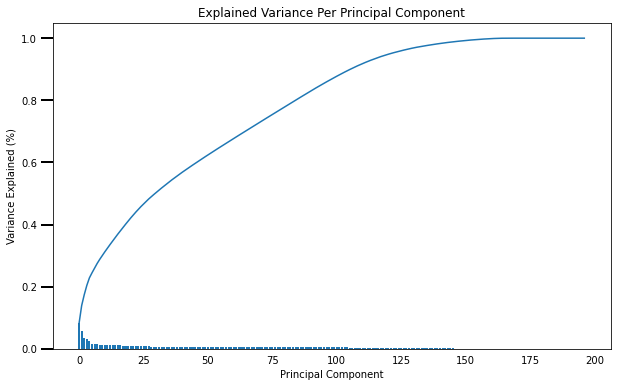

In [21]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    This function is directly from course materials
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
  #  for i in range(num_components):
  #      ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

scree_plot(pca)

cumVals = np.cumsum(pca.explained_variance_ratio_)
print('\nAt {}-th component, the cummulative explained variance is above 80%.'.format(np.where(cumVals>0.8)[0][0]+1))




In [22]:
# Re-apply PCA to the data while selecting for number of components to retain.
# 85 components are chosen, the minimal number of components that gives a >80% explainable variance
nComp = 85
pca = PCA(nComp)
azdias_pca = pca.fit_transform(azdias_impscl)


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

<span style="color:blue">

#### Answer:
85 principal components are chosen. This is the minimal number of components that can make the cummulative explainable variance higher than 80%
    
</span>

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [23]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_sortFeatWeight(pca, ith, featNames):
    '''
    Sort the features based on their weights in an appointed principal component 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
           ith - ith principal component
           featNames - feature names
    OUTPUT:
           sortW - a dictionary of features sorted by weights
    '''
    featW = dict()
    
    for i in range(0,len(featNames)):
        featW[featNames[i]] = pca.components_[ith-1][i]
          
    sortW = dict(sorted(featW.items(), key=lambda x:x[1], reverse = True))
    
    print('{}th component explained'.format(ith), pca.explained_variance_ratio_[ith-1]*100, '% variance.')
    print('\nThe sorted weights for features of the {}th component are:'.format(ith))
    for key, value in sortW.items():
        print(key, ' : ', value)
        
    return sortW

sortW_1st = pca_sortFeatWeight(pca, 1, azdias_impscl.columns)


1th component explained 8.251445252367045 % variance.

The sorted weights for features of the 1th component are:
LP_STATUS_GROB_1.0  :  0.18862338649513624
HH_EINKOMMEN_SCORE  :  0.1800128789888034
WEALTH  :  0.17940804777274486
PLZ8_ANTG3  :  0.17828564133621227
PLZ8_ANTG4  :  0.17323891268855704
PLZ8_BAUMAX  :  0.1697162036163193
ORTSGR_KLS9  :  0.15258354238564964
EWDICHTE  :  0.15072050530767545
FINANZ_HAUSBAUER  :  0.14766988339300424
KBA05_ANTG4  :  0.1270467941118888
LP_STATUS_FEIN_1.0  :  0.12651844250614702
PLZ8_ANTG2  :  0.12178816497579859
KBA05_ANTG3  :  0.11425630720662786
ANZ_HAUSHALTE_AKTIV  :  0.11346588812749199
ARBEIT  :  0.11226414212604771
CAMEO_DEUG_2015_9  :  0.11003257681789354
LP_STATUS_FEIN_2.0  :  0.10659886445520465
RELAT_AB  :  0.10490201170722019
FINANZTYP_1  :  0.10143088252234717
FINANZ_SPARER  :  0.09924574722976619
LP_FAMILIE_FEIN_1.0  :  0.09864536375301393
LP_FAMILIE_GROB_1.0  :  0.09864536375301393
CAMEO_DEUG_2015_8  :  0.09034822144032102
ZABEOTYP_5

In [24]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

sortW_2nd = pca_sortFeatWeight(pca, 2, azdias_impscl.columns)


2th component explained 5.679792018493606 % variance.

The sorted weights for features of the 2th component are:
ALTERSKATEGORIE_GROB  :  0.23771846561796214
FINANZ_VORSORGER  :  0.22324385374950945
ZABEOTYP_3  :  0.19943465364471094
SEMIO_ERL  :  0.181327749321247
SEMIO_LUST  :  0.16645276599081787
RETOURTYP_BK_S  :  0.15546157739672473
W_KEIT_KIND_HH  :  0.12767382868532504
CJT_GESAMTTYP_2.0  :  0.1111204526146215
FINANZ_MINIMALIST  :  0.10210299229182805
FINANZTYP_5  :  0.09726903084660019
FINANZTYP_2  :  0.0971906069032752
LP_STATUS_FEIN_1.0  :  0.08538985096459178
SHOPPER_TYP_3.0  :  0.07542910519988272
FINANZ_HAUSBAUER  :  0.07508256790308614
CJT_GESAMTTYP_1.0  :  0.07181781547547757
NATIONALITAET_KZ_1.0  :  0.07123434910677047
SEMIO_KRIT  :  0.0705518723674733
FINANZTYP_6  :  0.06928318064781355
LP_FAMILIE_FEIN_1.0  :  0.05888147823749098
LP_FAMILIE_GROB_1.0  :  0.05888147823749098
GFK_URLAUBERTYP_4.0  :  0.057829342643812266
WOHNDAUER_2008  :  0.057049411585255186
SEMIO_KAEM  :

In [25]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
sortW_3rd = pca_sortFeatWeight(pca, 3, azdias_impscl.columns)


3th component explained 3.487959476974402 % variance.

The sorted weights for features of the 3th component are:
SEMIO_VERT  :  0.3141518742786272
SEMIO_FAM  :  0.25500288482776756
SEMIO_SOZ  :  0.2538240007128734
SEMIO_KULT  :  0.24652445334397266
FINANZTYP_5  :  0.13758871363345154
FINANZ_MINIMALIST  :  0.13106210122157666
ZABEOTYP_1  :  0.12177155484302968
SHOPPER_TYP_0.0  :  0.12022327372222799
SEMIO_REL  :  0.11051946821160584
GREEN_AVANTGARDE  :  0.09206163380530678
MOVEMENT  :  0.09206163380530677
SEMIO_MAT  :  0.08729971632501837
ORTSGR_KLS9  :  0.07532222487554954
EWDICHTE  :  0.07471198393986038
RETOURTYP_BK_S  :  0.07289627764717323
LP_STATUS_FEIN_10.0  :  0.06736546427301159
LP_STATUS_GROB_5.0  :  0.06736546427301159
PLZ8_BAUMAX  :  0.056478142196062814
W_KEIT_KIND_HH  :  0.054755627669122786
PLZ8_ANTG4  :  0.05458198237451529
PLZ8_ANTG3  :  0.05427675046315553
SHOPPER_TYP_1.0  :  0.051550345172624364
LP_STATUS_FEIN_3.0  :  0.04704562588835842
ZABEOTYP_6  :  0.0458782640046

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

<span style="color:blue">

#### Answer:
For the 1st principal component:
<ul>
    <li> 'LP_STATUS_GROB_1.0' and 'MOBI_REGIO' have the most positive and negative weights, respectively. This indicates 'LP_STATUS_GROB_1.0' increases closer to 1, 'MOBI_REGIO' decreases. It suggests the people in low income status show a higher movement tendency. </li>
    <li>'LP_STATUS_GROB_1.0' and 'HH_EINKOMMEN_SCORE' both have similarly high positive weights. If 'LP_STATUS_GROB_1.0' increases closer to 1, 'HH_EINKOMMEN_SCORE' will increase to a high value, too. People in low income status have very low estimated household net income. This can be an attestment showing the previous analyses are correct.</li>
    <li>'MOBI_REGIO' and 'KBA05_ANTG1' both have similarly high negative weights. A high 'MOBI_REGIO' (low movement pattern) corresponds to a high 'KBA05_ANTG1' (high share of 1-2 family homes in the microcell). </li>
</ul>    
For the 2nd principal component:
<ul>    
    <li>'ALTERSKATEGORIE_GROB' and 'GENERATION' have the most positive and negative weights, respectively. A higher 'ALTERSKATEGORIE_GROB' (a high estimated age) correlates with a low 'GENERATION' (earlier generation, older age). This is another supporting result showing the prevous analyses are correct. </li>
    <li>'ALTERSKATEGORIE_GROB' and 'FINANZ_VORSORGER' both have similarly high positive weights. A higher estimated age is related to a high 'FINANZ_VORSORGER' value (low "be prepared" finance topology ).</li>
    <li>'FINANZ_SPARER' and 'GENERATION' have similarly high negative weights. A higher 'FINANZ_SPARER' value (lower tendency of money saver) is related to a higher 'GENERATION' value (younger generation). This result matches our common sense.</li>
</ul>   
For the 3rd principal component:
<ul>    
    <li>'SEMIO_VERT' and 'ANREDE_KZ' have the most positive and negative weights, respectively. A higher 'SEMIO_VERT' (a low affinity in dreamful personality) correlates with a low 'ANREDE_KZ' value (male gender). This result matches our common sense. </li>
    <li>'SEMIO_VERT' and 'SEMIO_FAM' both have similarly high positive weights. A higher 'SEMIO_VERT' (a low affinity in dreamful personality) is related to a high 'SEMIO_FAM' value (a low affinity in familly-minded personality ).</li>
    <li>'SEMIO_KAEM' and 'ANREDE_KZ' have similarly high negative weights. A higher 'SEMIO_KAEM' value (lower affinity in combative personality) is related to a higher 'ANREDE_KZ' value (female gender). This result matches our common sense.</li>
</ul>    
</span>

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [26]:
from sklearn.cluster import KMeans

# Over a number of different cluster counts...
nCenters  = range(1, 15)
scores    = []
#scores_inertia = []

for iCenter in nCenters:
    print('Calculating K = {}'.format(iCenter))
    
    # run k-means clustering on the data and...
    modKmeans = KMeans(n_clusters=iCenter)
    modelFit  = modKmeans.fit(azdias_pca)
    # compute the average within-cluster distances.
    scores.append(np.abs(modelFit.score(azdias_pca))) # calculate sum of squared distance
#    scores_inertia.append(modelFit.inertia_) # the same as abs(score) in previous line

scores = np.sqrt(scores) # convert to average distance
    

Calculating K = 1
Calculating K = 2
Calculating K = 3
Calculating K = 4
Calculating K = 5
Calculating K = 6
Calculating K = 7
Calculating K = 8
Calculating K = 9
Calculating K = 10
Calculating K = 11
Calculating K = 12
Calculating K = 13
Calculating K = 14


Text(0.5, 1.0, 'Elbow Method Plot')

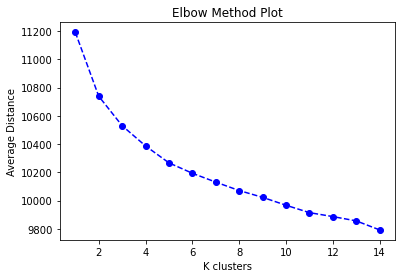

In [28]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure()    
plt.plot(nCenters, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K clusters')
plt.ylabel('Average Distance')
plt.title('Elbow Method Plot')  
    

In [29]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

nCenters = 5  # set 5 clusters
modKmeans = KMeans(n_clusters=nCenters)
modelFit  = modKmeans.fit(azdias_pca)
dataLabel = modelFit.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

<span style="color:blue">

#### Answer:
The population data are segmented into 5 clusters. The within-cluster average distance - k plot above shows the elbow is not very obvious for the data. But it can still be observed that when k > 5, the decrease in average distance is more linear than the trend for k <= 5.  
  
</span>

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [30]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [31]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Drop the same columns as in the general demographics data, regardless of the actual missing data
# because the models were all built based on the remaining features of the general demographics data
# Drop the rows when the row have missing data > a threshold
customers_encoded =  clean_data(customers, feat_info, feat_drop[0:-2], rowThre)



6 columns are dropped. They are:
['AGER_TYP' 'GEBURTSJAHR' 'TITEL_KZ' 'ALTER_HH' 'KK_KUNDENTYP'
 'KBA05_BAUMAX']
The dataset now have 191652 rows and 79 columns.
49962 rows are dropped.
The dataset now have 141690 rows and 79 columns.

Categorical features include:
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

Mixed-type features include:
15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

Categorical features not to be encoded (binary and numeric)

<ipython-input-17-aa850839d141>:138: RuntimeWarning: invalid value encountered in remainder
  newCols['LIFE_STAGE'] = np.mod(np.float64(dfOut[feature]),10)  # mod(nan, 10) will give a warning, but returns nan


Dimensions of the final dataset are (141690, 196)
The columns in the  final dataset are:
['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP_1.0', 'CJT_GESAMTTYP_2.0', 'CJT_GESAMTTYP_3.0', 'CJT_GESAMTTYP_4.0', 'CJT_GESAMTTYP_5.0', 'CJT_GESAMTTYP_6.0', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP_1', 'FINANZTYP_2', 'FINANZTYP_3', 'FINANZTYP_4', 'FINANZTYP_5', 'FINANZTYP_6', 'GFK_URLAUBERTYP_1.0', 'GFK_URLAUBERTYP_2.0', 'GFK_URLAUBERTYP_3.0', 'GFK_URLAUBERTYP_4.0', 'GFK_URLAUBERTYP_5.0', 'GFK_URLAUBERTYP_6.0', 'GFK_URLAUBERTYP_7.0', 'GFK_URLAUBERTYP_8.0', 'GFK_URLAUBERTYP_9.0', 'GFK_URLAUBERTYP_10.0', 'GFK_URLAUBERTYP_11.0', 'GFK_URLAUBERTYP_12.0', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN_1.0', 'LP_FAMILIE_FEIN_2.0', 'LP_FAMILIE_FEIN_3.0', 'LP_FAMILIE_FEIN_4.0', 'LP_FAMILIE_FEIN_5.0', 'LP_FAMILIE_FEIN_6.0', 'LP_FAMILIE_FEIN_7.0', 'LP_FAMILIE_FEIN

In [32]:
# After using clean_data(), customer dataset has 1 feature less than the general dataset. 
# This is because feature "GEBAEUDETYP" does not have a value 5.0 in the customer dataset. So after one-hot encoding, 
# the customer dataset does not have the feature "GEBAEUDETYP_5.0"

# Here we do one addtional preprocessing step for the customer dataset - add to it a column "GEBAEUDETYP_5.0" and fill it with NaN

while len(customers_encoded.columns) < len(azdias_encoded.columns):
    for iFeature in range(len(customers_encoded.columns)):
        if customers_encoded.columns[iFeature] != azdias_encoded.columns[iFeature]:
            customers_encoded.insert(iFeature, azdias_encoded.columns[iFeature],np.nan)
            break
        
print('After adding missing features, the customer data has a size of',customers_encoded.shape)
print('The columns in the  final dataset are:')
print(list(customers_encoded.columns))


After adding missing features, the customer data has a size of (141690, 197)
The columns in the  final dataset are:
['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP_1.0', 'CJT_GESAMTTYP_2.0', 'CJT_GESAMTTYP_3.0', 'CJT_GESAMTTYP_4.0', 'CJT_GESAMTTYP_5.0', 'CJT_GESAMTTYP_6.0', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP_1', 'FINANZTYP_2', 'FINANZTYP_3', 'FINANZTYP_4', 'FINANZTYP_5', 'FINANZTYP_6', 'GFK_URLAUBERTYP_1.0', 'GFK_URLAUBERTYP_2.0', 'GFK_URLAUBERTYP_3.0', 'GFK_URLAUBERTYP_4.0', 'GFK_URLAUBERTYP_5.0', 'GFK_URLAUBERTYP_6.0', 'GFK_URLAUBERTYP_7.0', 'GFK_URLAUBERTYP_8.0', 'GFK_URLAUBERTYP_9.0', 'GFK_URLAUBERTYP_10.0', 'GFK_URLAUBERTYP_11.0', 'GFK_URLAUBERTYP_12.0', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN_1.0', 'LP_FAMILIE_FEIN_2.0', 'LP_FAMILIE_FEIN_3.0', 'LP_FAMILIE_FEIN_4.0', 'LP_FAMILIE_FEIN_5.0', 'LP_FAMILIE_FEIN_6.0', 'LP_FAMILIE_

In [33]:
#Impute data, replacing NANs in the customer data with the median data calculated from the general dataset
customers_impscl  = pd.DataFrame(median_imputer.transform(customers_encoded),columns = customers_encoded.columns)

print('There are {} NaN\'s left'.format(customers_impscl.isna().sum().sum()))

There are 0 NaN's left


In [34]:
# Scale features in the customer data using the means and standard deviations from the general dataset
customers_impscl = pd.DataFrame(staScaler.transform(customers_impscl),columns = customers_encoded.columns)

# It can be observed that the mean and std are not equalt to 0 and 1, respectivley
print('Mean, Std and statistics for each features are:')
print(customers_impscl.describe())

Mean, Std and statistics for each features are:
       ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP_1.0  \
count         141690.000000  141690.000000      141690.000000   
mean               0.678834      -0.381889           0.134441   
std                0.717777       0.941809           1.141249   
min               -1.766591      -1.043916          -0.363908   
25%                0.200523      -1.043916          -0.363908   
50%                1.184079      -1.043916          -0.363908   
75%                1.184079       0.957932          -0.363908   
max                1.184079       0.957932           2.747948   

       CJT_GESAMTTYP_2.0  CJT_GESAMTTYP_3.0  CJT_GESAMTTYP_4.0  \
count      141690.000000      141690.000000      141690.000000   
mean            0.285010          -0.058772          -0.164127   
std             1.183665           0.949178           0.884327   
min            -0.463825          -0.475629          -0.575048   
25%            -0.463825          -0

In [36]:
# Transform the data into the space described by the same 85 principal components as for the general dataset
customers_pca = pca.transform(customers_impscl)

In [37]:
# predicting the cluster labels using the model from the general dataset
dataLabel_customers = modelFit.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

The percentages for each cluster in the general data and customers data are:
                  general  customers
Cluster 1        0.182639   0.204318
Cluster 2        0.236616   0.163239
Cluster 3        0.135287   0.332149
Cluster 4        0.157941   0.026517
Cluster 5        0.182735   0.013086
Dropped Samples  0.104782   0.260691


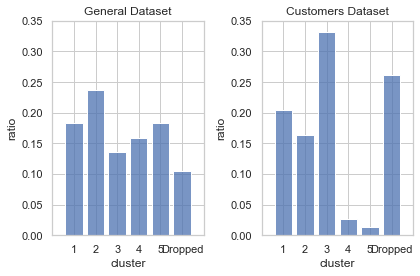

In [38]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

prop = np.empty((nCenters+1,2))
for iCenter in range(nCenters):
    prop[iCenter,0] = np.count_nonzero(dataLabel == iCenter)
    prop[iCenter,1] = np.count_nonzero(dataLabel_customers == iCenter)

# take the rows with > threshold missing data as one cluster     
prop[nCenters, 0] = azdias.shape[0]-azdias_encoded.shape[0]
prop[nCenters, 1] = customers.shape[0]-customers_encoded.shape[0]

prop[:,0] = prop[:,0]/azdias.shape[0]
prop[:,1] = prop[:,1]/customers.shape[0]

propdf = pd.DataFrame(data = prop, index = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Dropped Samples'], columns=['general','customers'],)

print('The percentages for each cluster in the general data and customers data are:')
print(propdf)


dataLabeldf = np.append(dataLabel, [5 for i in range(azdias.shape[0]-azdias_encoded.shape[0])]) 
dataLabeldf = np.append(dataLabeldf, dataLabel_customers)
dataLabeldf = np.append(dataLabeldf, [5 for i in range(customers.shape[0]-customers_encoded.shape[0])])

dataLabelDF = pd.DataFrame(index = range(len(dataLabeldf)),columns = ['cluster','dataset'] )
dataLabelDF['cluster'] = dataLabeldf
dataLabelDF['dataset'] = np.append(['general' for i in range(azdias.shape[0])], ['customers' for i in range(customers.shape[0])])

sns.set(style="whitegrid")

plt.figure()

#ax = sns.histplot(data = dataLabelDF, x='cluster',hue='dataset', stat = 'probability', multiple="dodge", discrete = True, shrink = 0.8)
#ax.get_xticks
#ax.set_xticklabels(['','Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Dropped',''])
#ax.set_ylabel('ratio')

# plt.show()

# countplot() cannot plot ratio or percentage, so use histplot() instead
# Plotting two groups use "hue" returns the pertentage in the entire dataset of two groups, instead of percentage within one group
# So have to use histplot + subplot to separate the two groups into two subplots
ax1 = plt.subplot(1,2,1) 
sns.histplot(data = dataLabelDF.iloc[0:azdias.shape[0]], x ='cluster',stat = 'probability', discrete = True, shrink = 0.8)
ax1.set_title('General Dataset')
ax1.set_xticks([-1, 0, 1, 2,3,4,5,6])
ax1.set_xticklabels(['','1','2','3','4','5','Dropped',''])
ax1.set_ylabel('ratio')
ax1.set_ylim(0, 0.35)

ax2 = plt.subplot(1,2,2) 
sns.histplot(data = dataLabelDF.iloc[azdias.shape[0]:], x ='cluster',stat = 'probability', discrete = True, shrink = 0.8)
ax2.set_title('Customers Dataset')
ax2.set_xticks([-1, 0, 1, 2,3,4,5,6])
ax2.set_xticklabels(['','1','2','3','4','5','Dropped',''])
ax2.set_xticklabels(['','1','2','3','4','5','Dropped',''])
ax2.set_ylabel('ratio')
ax2.set_ylim(0, 0.35)

plt.tight_layout()   
plt.show()


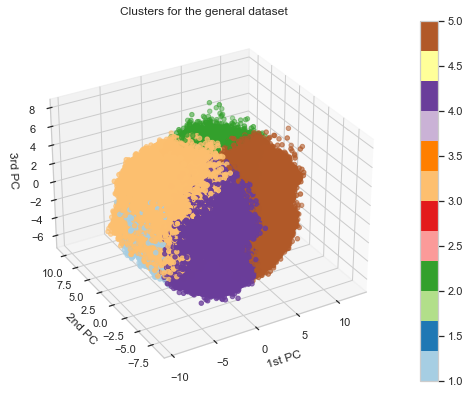

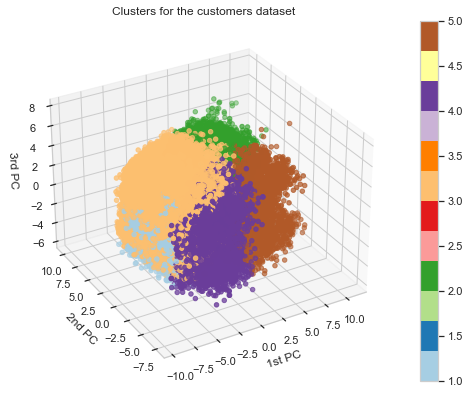

In [50]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# CLuster 3 and the "Dropped" clusters are over represented in the customer data

#Visualize the clusters in the space of first 3 principal components
# run interactive mode
%matplotlib notebook  

from mpl_toolkits.mplot3d import Axes3D

# plot clusters in the general dataset

fig = plt.figure(figsize=(10,5))
#ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig, azim = 240)
scatt = ax.scatter(azdias_pca[:, 0], azdias_pca[:, 1], azdias_pca[:, 2], c=dataLabel[:]+1, cmap='Paired', label = ('1','2','3','4','5'))
ax.set_xlabel('1st PC')
ax.set_ylabel('2nd PC')
ax.set_zlabel('3rd PC')
#ax.set_legend()
ax.set_title('Clusters for the general dataset')
fig.colorbar(scatt)
 

plt.show()

# plot clusters in the clustomers dataset
fig = plt.figure(figsize=(10,5))
fig.add_subplot(projection='3d')
#fig, ax1 = plt.subplot(1,2,1) 
ax = Axes3D(fig,azim = 240)
scatt = ax.scatter(customers_pca[:, 0], customers_pca[:, 1], customers_pca[:, 2], c=dataLabel_customers[:]+1, cmap='Paired', label = ('1','2','3','4','5'))
ax.set_xlabel('1st PC')
ax.set_ylabel('2nd PC')
ax.set_zlabel('3rd PC')
#ax.set_legend()
ax.set_title('Clusters for the customers dataset')
fig.colorbar(scatt)

plt.show()

#Take cluster 3 for example. Cluster 3 represent points that are higher in 3rd PC, lower in 1st PC


In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# CLusters 4 and 5 are underrepresented in the customer data
# Take Cluster 5 for example. Cluster 5 represent points that are high in 2nd PC, and in the middel for 1st PC


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

<span style="color:blue">

#### Answer:
Cluster 3 is one segment that are relatively popular with the mail-order company. People in this cluster are low in 1st PC but high in 3rd PC. Combined with the weights of variables in the 1st and 3rd PCs, it can be interpretted that people having not low income status ('LP_STATUS_GROB_1.0' close to zero), having not low estimated household net income (low in 'HH_EINKOMMEN_SCORE'), lower movement tendency (high in 'MOBI_REGIO'), higher share of 1-2 family homes in the microcell (high in 'KBA05_ANTG1'), lower affinity in dreamful personality (high in 'SEMIO_VERT'), lower affinity in familly-minded personality (high in 'SEMIO_FAM' value), higher affinity in combative personality (low in 'SEMIO_KAEM' value) and male gender (low in 'ANREDE_KZ' value) are relatively popular with the mail-order company.
    
Cluster 5 is one segment that are relatively unpopular with the company. People in this cluster are high in 2nd PC but around middle in 1st PC. So it can be interpretted that people having a higher estimated age (high in 'ALTERSKATEGORIE_GROB'), lower "be prepared" finance topology (high in 'FINANZ_VORSORGER'), a higher tendency of money saver (low in 'FINANZ_SPARER'), older generation (low in 'GENERATION'), middle in income status ('LP_STATUS_GROB_1.0'), middle in estimated household net income ('HH_EINKOMMEN_SCORE'), middle move tendency ('MOBI_REGIO'), middel share of 1-2 family homes in the microcell ('KBA05_ANTG1') are relatively unpopular with the company.

</span>

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.